In [3]:
import pandas as pd
import numpy as np

sampled_data = pd.read_parquet("sampled_simulations_5th.parquet")

In [19]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Add normalized time to the features
def normalize_time_per_simulation(df, simulation_column, time_column):
    # Normalize time for each simulation
    df['Normalized_Time'] = df.groupby(simulation_column)[time_column].transform(lambda x: x / x.max())
    return df

# Apply the function to normalize time
sampled_data = normalize_time_per_simulation(sampled_data, simulation_column='Simulation_ID', time_column='Time (s)')

# Update features (X) to include normalized time
X = sampled_data.drop(columns=['Simulation_ID', 'Time (s)', 
                               '5nm_retentate', '5nm_permeate', '5nm_cumulative_yield', '5nm_size_solute',
                               '40nm_retentate', '40nm_permeate', '40nm_cumulative_yield', '40nm_size_solute',
                               '70nm_retentate', '70nm_permeate', '70nm_cumulative_yield', '70nm_size_solute',
                               '120nm_retentate', '120nm_permeate', '120nm_cumulative_yield', '120nm_size_solute',
                               '190nm_retentate', '190nm_permeate', '190nm_cumulative_yield', '190nm_size_solute',
                               '300nm_retentate', '300nm_permeate', '300nm_cumulative_yield', '300nm_size_solute',
                               '700nm_retentate', '700nm_permeate', '700nm_cumulative_yield', '700nm_size_solute',
                               '2500nm_retentate', '2500nm_permeate', '2500nm_cumulative_yield', '2500nm_size_solute',
                               'Diavolumes'])


Y = sampled_data[['5nm_retentate', '5nm_permeate',
                  '40nm_retentate', '40nm_permeate', 
                  '70nm_retentate', '70nm_permeate',   
                  '120nm_retentate', '120nm_permeate',  
                  '190nm_retentate', '190nm_permeate', 
                  '300nm_retentate', '300nm_permeate', 
                  '700nm_retentate', '700nm_permeate', 
                  '2500nm_retentate', '2500nm_permeate',
                  'Diavolumes']]
# Add normalized time to the features

groups = sampled_data['Simulation_ID']

# Define the number of components for PLS


# Split data into train-validation and test sets
group_split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [26]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# # Add normalized time to the features


# Apply log transformation to all features
X_sqrt = np.sqrt(X)

# Define the number of components for PLS
n_components = 5

# Split data into train-validation and test sets
# group_split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_val_idx, test_idx = next(group_split.split(X_sqrt, Y, groups))

X_train_val, X_test = X_sqrt.iloc[train_val_idx], X_sqrt.iloc[test_idx]
Y_train_val, Y_test = Y.iloc[train_val_idx], Y.iloc[test_idx]
groups_train_val = groups.iloc[train_val_idx]

# Initialize scalers
feature_scaler = StandardScaler()

# Set up 5-fold cross-validation
n_folds = 5
group_kfold = GroupKFold(n_splits=n_folds)

# Initialize placeholders for aggregate metrics
validation_q2_list, validation_r2_list = [], []
validation_mae_list, validation_mape_list = [], []
validation_mse_list, validation_rmse_list = [], []

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X_train_val, Y_train_val, groups_train_val), start=1):
    # Split data
    X_train_fold, X_val_fold = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    Y_train_fold, Y_val_fold = Y_train_val.iloc[train_idx], Y_train_val.iloc[val_idx]

    # Scale data
    X_train_fold_scaled = feature_scaler.fit_transform(X_train_fold)

    X_val_fold_scaled = feature_scaler.transform(X_val_fold)
   

    # Train the model
    pls_model_sqrt= PLSRegression(n_components=n_components)
    pls_model_sqrt.fit(X_train_fold_scaled, Y_train_fold)
    
    # Predict on validation set
    Y_val_pred = pls_model_sqrt.predict(X_val_fold_scaled)
    

    # Compute metrics for validation set
    val_mse = mean_squared_error(Y_val_fold ,Y_val_pred, multioutput='raw_values')
    val_rmse = np.sqrt(val_mse)
    val_r2 = r2_score(Y_val_fold, Y_val_pred, multioutput='uniform_average')
    val_mae = mean_absolute_error(Y_val_fold, Y_val_pred, multioutput='raw_values')



    # Aggregate metrics across folds
   
    validation_r2_list.append(val_r2)
    validation_mae_list.append(np.mean(val_mae))
    validation_mse_list.append(np.mean(val_mse))
    validation_rmse_list.append(np.mean(val_rmse))

# Compute averages across all folds for validation
# Compute averages across all folds for validation

avg_val_r2 = np.mean(validation_r2_list)
avg_val_mae = np.mean(validation_mae_list)
avg_val_mse = np.mean(validation_mse_list)
avg_val_rmse = np.mean(validation_rmse_list)

# Print validation results
print(f"\nValidation Results (Averaged Across Folds):")

print(f"  R²: {avg_val_r2:.7f}")
print(f"  MAE: {avg_val_mae:.7f}")
print(f"  MSE: {avg_val_mse:.7f}")
print(f"  RMSE: {avg_val_rmse:.7f}")

# Compute metrics per target for validation
print("\nValidation Metrics Per Target:")
for i, target in enumerate(Y.columns):
    target_val_r2 = r2_score(Y_val_fold.iloc[:, i], Y_val_pred[:, i])
    target_val_mse = mean_squared_error(Y_val_fold.iloc[:, i], Y_val_pred[:, i])
    target_val_rmse = np.sqrt(target_val_mse)
    target_val_mae = mean_absolute_error(Y_val_fold.iloc[:, i], Y_val_pred[:, i])
    
    print(f"Target: {target}")
    print(f"  R²: {target_val_r2:.7f}")

    print(f"  MAE: {target_val_mae:.7f}")
    print(f"  MSE: {target_val_mse:.7f}")
    print(f"  RMSE: {target_val_rmse:.7f}")

X_test_scaled = feature_scaler.transform(X_test)

# Evaluate on test set
Y_test_pred = pls_model_sqrt.predict(X_test_scaled)

# Compute metrics for test set
test_mse = mean_squared_error(Y_test, Y_test_pred, multioutput='raw_values')
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(Y_test, Y_test_pred, multioutput='uniform_average')
test_mae = mean_absolute_error(Y_test, Y_test_pred, multioutput='raw_values')

# Print test results
print(f"\nTest Results:")

print(f"  R²: {test_r2:.7f}")
print(f"  MAE: {np.mean(test_mae):.7f}")
print(f"  MSE: {np.mean(test_mse):.7f}")
print(f"  RMSE: {np.mean(test_rmse):.7f}")

# Compute metrics per target for test
print("\nTest Metrics Per Target:")
for i, target in enumerate(Y.columns):
    target_test_r2 = r2_score(Y_test.iloc[:, i], Y_test_pred[:, i])
    target_test_mse = mean_squared_error(Y_test.iloc[:, i], Y_test_pred[:, i])
    target_test_rmse = np.sqrt(target_test_mse)
    target_test_mae = mean_absolute_error(Y_test.iloc[:, i], Y_test_pred[:, i])
  
    print(f"Target: {target}")
    print(f"  R²: {target_test_r2:.7f}")

    print(f"  MAE: {target_test_mae:.7f}")
    print(f"  MSE: {target_test_mse:.7f}")
    print(f"  RMSE: {target_test_rmse:.7f}")



Validation Results (Averaged Across Folds):
  R²: 0.7257435
  MAE: 0.0195070
  MSE: 0.0112495
  RMSE: 0.0258071

Validation Metrics Per Target:
Target: 5nm_retentate
  R²: 0.6869503
  MAE: 0.0000834
  MSE: 0.0000000
  RMSE: 0.0001038
Target: 5nm_permeate
  R²: 0.7188924
  MAE: 0.0000141
  MSE: 0.0000000
  RMSE: 0.0000174
Target: 40nm_retentate
  R²: 0.7447781
  MAE: 0.0001191
  MSE: 0.0000000
  RMSE: 0.0001465
Target: 40nm_permeate
  R²: 0.6821389
  MAE: 0.0000196
  MSE: 0.0000000
  RMSE: 0.0000241
Target: 70nm_retentate
  R²: 0.7713407
  MAE: 0.0003105
  MSE: 0.0000002
  RMSE: 0.0003967
Target: 70nm_permeate
  R²: 0.5472759
  MAE: 0.0000488
  MSE: 0.0000000
  RMSE: 0.0000627
Target: 120nm_retentate
  R²: 0.8510889
  MAE: 0.0002394
  MSE: 0.0000001
  RMSE: 0.0003094
Target: 120nm_permeate
  R²: 0.4905372
  MAE: 0.0000346
  MSE: 0.0000000
  RMSE: 0.0000460
Target: 190nm_retentate
  R²: 0.9229684
  MAE: 0.0000972
  MSE: 0.0000000
  RMSE: 0.0001214
Target: 190nm_permeate
  R²: 0.4890714


In [30]:
random_sim_id

'Sim_6424'

In [32]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# # Add normalized time to the features
# def normalize_time_per_simulation(df, simulation_column, time_column):
# #     df['Normalized_Time'] = df.groupby(simulation_column)[time_column].transform(lambda x: x / x.max())
# #     return df

# # Apply the function to normalize time
sampled_data = normalize_time_per_simulation(sampled_data, simulation_column='Simulation_ID', time_column='Time (s)')

# Define features and targets
X = sampled_data.drop(columns=['Simulation_ID', 'Time (s)', 
                               '5nm_retentate', '5nm_permeate', '5nm_cumulative_yield', '5nm_size_solute',
                               '40nm_retentate', '40nm_permeate', '40nm_cumulative_yield', '40nm_size_solute',
                               '70nm_retentate', '70nm_permeate', '70nm_cumulative_yield', '70nm_size_solute',
                               '120nm_retentate', '120nm_permeate', '120nm_cumulative_yield', '120nm_size_solute',
                               '190nm_retentate', '190nm_permeate', '190nm_cumulative_yield', '190nm_size_solute',
                               '300nm_retentate', '300nm_permeate', '300nm_cumulative_yield', '300nm_size_solute',
                               '700nm_retentate', '700nm_permeate', '700nm_cumulative_yield', '700nm_size_solute',
                               '2500nm_retentate', '2500nm_permeate', '2500nm_cumulative_yield', '2500nm_size_solute',
                               'Diavolumes', '2500nm_sieving_coefficient', '120nm_sieving_coefficient'])

# Apply log transformation to all features
X_sqrt = np.sqrt(X)
Y_sqrt = np.sqrt(np.where(Y < 0, 0, Y))

# # Define target variables
# Y = sampled_data[['5nm_retentate', '5nm_permeate',
#                   '40nm_retentate', '40nm_permeate', 
#                   '70nm_retentate', '70nm_permeate',   
#                   '120nm_retentate', '120nm_permeate',  
#                   '190nm_retentate', '190nm_permeate', 
#                   '300nm_retentate', '300nm_permeate', 
#                   '700nm_retentate', '700nm_permeate', 
#                   '2500nm_retentate', '2500nm_permeate',
#                   'Diavolumes']]

# Apply log transformation to targets

# groups = sampled_data['Simulation_ID']

# Define the number of components for PLS
n_components = 5

# Split data into train-validation and test sets
# group_split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_val_idx, test_idx = next(group_split.split(X_sqrt, Y_sqrt, groups))

X_train_val, X_test = X_sqrt.iloc[train_val_idx], X_sqrt.iloc[test_idx]
Y_train_val, Y_test = Y_sqrt[train_val_idx], Y_sqrt[test_idx]
groups_train_val = groups.iloc[train_val_idx]

# Initialize scalers
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# Set up 5-fold cross-validation
n_folds = 5
group_kfold = GroupKFold(n_splits=n_folds)

# Initialize placeholders for aggregate metrics
validation_q2_list, validation_r2_list = [], []
validation_mae_list, validation_mape_list = [], []
validation_mse_list, validation_rmse_list = [], []

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X_train_val, Y_train_val, groups_train_val), start=1):
    # Split data
    X_train_fold, X_val_fold = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    Y_train_fold, Y_val_fold = Y_train_val[train_idx], Y_train_val[val_idx]

    # Scale data
    X_train_fold_scaled = feature_scaler.fit_transform(X_train_fold)
    Y_train_fold_scaled = target_scaler.fit_transform(Y_train_fold)
    X_val_fold_scaled = feature_scaler.transform(X_val_fold)
    Y_val_fold_scaled = target_scaler.transform(Y_val_fold)

    # Train the model
    pls_model_sqrt_2_add= PLSRegression(n_components=n_components)
    pls_model_sqrt_2_add.fit(X_train_fold_scaled, Y_train_fold_scaled)

    # Predict on validation set
    Y_val_pred = pls_model_sqrt_2_add.predict(X_val_fold_scaled)
    
    Y_val_pred = target_scaler.inverse_transform(Y_val_pred)

    Y_val_pred = np.square(Y_val_pred)
    Y_val_fold = np.square(Y_val_fold)


    # Compute metrics only on valid data
    val_mse = mean_squared_error(Y_val_fold, Y_val_pred, multioutput='raw_values')
    val_rmse = np.sqrt(val_mse)
    val_r2 = r2_score(Y_val_fold, Y_val_pred, multioutput='uniform_average')
    val_mae = mean_absolute_error(Y_val_fold, Y_val_pred, multioutput='raw_values')

    

    # Aggregate metrics across folds
  
    validation_r2_list.append(val_r2)
    validation_mae_list.append(np.mean(val_mae))
    validation_mse_list.append(np.mean(val_mse))
    validation_rmse_list.append(np.mean(val_rmse))

# Compute averages across all folds for validation
# Compute averages across all folds for validation
avg_val_q2 = np.mean(validation_q2_list)
avg_val_r2 = np.mean(validation_r2_list)
avg_val_mae = np.mean(validation_mae_list)
avg_val_mse = np.mean(validation_mse_list)
avg_val_rmse = np.mean(validation_rmse_list)

# Print validation results
print(f"\nValidation Results (Averaged Across Folds):")

print(f"  R²: {avg_val_r2:.7f}")
print(f"  MAE: {avg_val_mae:.7f}")
print(f"  MSE: {avg_val_mse:.7f}")
print(f"  RMSE: {avg_val_rmse:.7f}")

# Compute metrics per target for validation
print("\nValidation Metrics Per Target:")
for i, target in enumerate(Y.columns):
    target_val_r2 = r2_score(Y_val_fold[:, i], Y_val_pred[:, i])
    target_val_mse = mean_squared_error(Y_val_fold[:, i], Y_val_pred[:, i])
    target_val_rmse = np.sqrt(target_val_mse)
    target_val_mae = mean_absolute_error(Y_val_fold[:, i], Y_val_pred[:, i])

    print(f"Target: {target}")
    print(f"  R²: {target_val_r2:.7f}")

    print(f"  MAE: {target_val_mae:.7f}")
    print(f"  MSE: {target_val_mse:.7f}")
    print(f"  RMSE: {target_val_rmse:.7f}")

X_test_scaled = feature_scaler.transform(X_test)
Y_test_scaled = target_scaler.transform(Y_test)

# Evaluate on test set
Y_test_pred = pls_model_sqrt_2_add.predict(X_test_scaled)
Y_test_pred_copy = Y_test_pred
Y_test_pred = target_scaler.inverse_transform(Y_test_pred)

Y_test_pred = np.square(Y_test_pred)
Y_test_copy = Y_test
Y_test = np.square(Y_test)

# Compute metrics for test set
test_mse = mean_squared_error(Y_test, Y_test_pred, multioutput='raw_values')
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(Y_test, Y_test_pred, multioutput='uniform_average')
test_mae = mean_absolute_error(Y_test, Y_test_pred, multioutput='raw_values')


# Print test results
print(f"\nTest Results:")

print(f"  R²: {test_r2:.7f}")
print(f"  MAE: {np.mean(test_mae):.7f}")
print(f"  MSE: {np.mean(test_mse):.7f}")
print(f"  RMSE: {np.mean(test_rmse):.7f}")

# # Compute metrics per target for test
print("\nTest Metrics Per Target:")
for i, target in enumerate(Y.columns):
    target_test_r2 = r2_score(Y_test[:, i], Y_test_pred[:, i])
    target_test_mse = mean_squared_error(Y_test[:, i], Y_test_pred[:, i])
    target_test_rmse = np.sqrt(target_test_mse)
    target_test_mae = mean_absolute_error(Y_test[:, i], Y_test_pred[:, i])
    
    print(f"Target: {target}")
    print(f"  R²: {target_test_r2:.7f}")

    print(f"  MAE: {target_test_mae:.7f}")
    print(f"  MSE: {target_test_mse:.7f}")
    print(f"  RMSE: {target_test_rmse:.7f}")


/Users/baochikhuc/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/baochikhuc/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Validation Results (Averaged Across Folds):
  R²: 0.7677665
  MAE: 0.0166490
  MSE: 0.0094389
  RMSE: 0.0236330

Validation Metrics Per Target:
Target: 5nm_retentate
  R²: 0.7625428
  MAE: 0.0000665
  MSE: 0.0000000
  RMSE: 0.0000904
Target: 5nm_permeate
  R²: 0.8272835
  MAE: 0.0000102
  MSE: 0.0000000
  RMSE: 0.0000137
Target: 40nm_retentate
  R²: 0.8025498
  MAE: 0.0000995
  MSE: 0.0000000
  RMSE: 0.0001288
Target: 40nm_permeate
  R²: 0.7677019
  MAE: 0.0000153
  MSE: 0.0000000
  RMSE: 0.0000206
Target: 70nm_retentate
  R²: 0.8082496
  MAE: 0.0002667
  MSE: 0.0000001
  RMSE: 0.0003633
Target: 70nm_permeate
  R²: 0.5976283
  MAE: 0.0000417
  MSE: 0.0000000
  RMSE: 0.0000592
Target: 120nm_retentate
  R²: 0.8818992
  MAE: 0.0001972
  MSE: 0.0000001
  RMSE: 0.0002755
Target: 120nm_permeate
  R²: 0.5283461
  MAE: 0.0000304
  MSE: 0.0000000
  RMSE: 0.0000443
Target: 190nm_retentate
  R²: 0.9505389
  MAE: 0.0000699
  MSE: 0.0000000
  RMSE: 0.0000973
Target: 190nm_permeate
  R²: 0.5276680


In [5]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# # Add normalized time to the features
def normalize_time_per_simulation(df, simulation_column, time_column):
    df['Normalized_Time'] = df.groupby(simulation_column)[time_column].transform(lambda x: x / x.max())
    return df

# # Apply the function to normalize time
sampled_data = normalize_time_per_simulation(sampled_data, simulation_column='Simulation_ID', time_column='Time (s)')

# Define features and targets
X = sampled_data.drop(columns=['Simulation_ID', 'Time (s)', 
                               '5nm_retentate', '5nm_permeate', '5nm_cumulative_yield', '5nm_size_solute',
                               '40nm_retentate', '40nm_permeate', '40nm_cumulative_yield', '40nm_size_solute',
                               '70nm_retentate', '70nm_permeate', '70nm_cumulative_yield', '70nm_size_solute',
                               '120nm_retentate', '120nm_permeate', '120nm_cumulative_yield', '120nm_size_solute',
                               '190nm_retentate', '190nm_permeate', '190nm_cumulative_yield', '190nm_size_solute',
                               '300nm_retentate', '300nm_permeate', '300nm_cumulative_yield', '300nm_size_solute',
                               '700nm_retentate', '700nm_permeate', '700nm_cumulative_yield', '700nm_size_solute',
                               '2500nm_retentate', '2500nm_permeate', '2500nm_cumulative_yield', '2500nm_size_solute',
                               'Diavolumes', '2500nm_sieving_coefficient', '120nm_sieving_coefficient'])

# Apply log transformation to all features


# # Define target variables
Y = sampled_data[['5nm_retentate', '5nm_permeate',
                  '40nm_retentate', '40nm_permeate', 
                  '70nm_retentate', '70nm_permeate',   
                  '120nm_retentate', '120nm_permeate',  
                  '190nm_retentate', '190nm_permeate', 
                  '300nm_retentate', '300nm_permeate', 
                  '700nm_retentate', '700nm_permeate', 
                  '2500nm_retentate', '2500nm_permeate',
                  'Diavolumes']]
X_sqrt = np.sqrt(X)
Y_sqrt = np.sqrt(np.where(Y < 0, 0, Y))

# Apply log transformation to targets

groups = sampled_data['Simulation_ID']

# Define the number of components for PLS
n_components = 5

# Split data into train-validation and test sets
group_split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_val_idx, test_idx = next(group_split.split(X_sqrt, Y_sqrt, groups))

X_train_val, X_test = X_sqrt.iloc[train_val_idx], X_sqrt.iloc[test_idx]
Y_train_val, Y_test = Y_sqrt[train_val_idx], Y_sqrt[test_idx]
groups_train_val = groups.iloc[train_val_idx]

# Initialize scalers
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# Set up 5-fold cross-validation
n_folds = 5
group_kfold = GroupKFold(n_splits=n_folds)

# Initialize placeholders for aggregate metrics
validation_q2_list, validation_r2_list = [], []
validation_mae_list, validation_mape_list = [], []
validation_mse_list, validation_rmse_list = [], []

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X_train_val, Y_train_val, groups_train_val), start=1):
    # Split data
    X_train_fold, X_val_fold = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    Y_train_fold, Y_val_fold = Y_train_val[train_idx], Y_train_val[val_idx]

    # Scale data
    X_train_fold_scaled = feature_scaler.fit_transform(X_train_fold)
    Y_train_fold_scaled = target_scaler.fit_transform(Y_train_fold)
    X_val_fold_scaled = feature_scaler.transform(X_val_fold)
    Y_val_fold_scaled = target_scaler.transform(Y_val_fold)

    # Train the model
    pls_model_sqrt_2_add= PLSRegression(n_components=n_components)
    pls_model_sqrt_2_add.fit(X_train_fold_scaled, Y_train_fold_scaled)

    # Predict on validation set
    Y_val_pred = pls_model_sqrt_2_add.predict(X_val_fold_scaled)
    
    Y_val_pred = target_scaler.inverse_transform(Y_val_pred)

    Y_val_pred = np.square(Y_val_pred)
    Y_val_fold = np.square(Y_val_fold)


   

X_test_scaled = feature_scaler.transform(X_test)
Y_test_scaled = target_scaler.transform(Y_test)

# Evaluate on test set
Y_test_pred = pls_model_sqrt_2_add.predict(X_test_scaled)
Y_test_pred_copy = Y_test_pred
Y_test_pred = target_scaler.inverse_transform(Y_test_pred)

Y_test_pred = np.square(Y_test_pred)
Y_test_copy = Y_test
Y_test = np.square(Y_test)



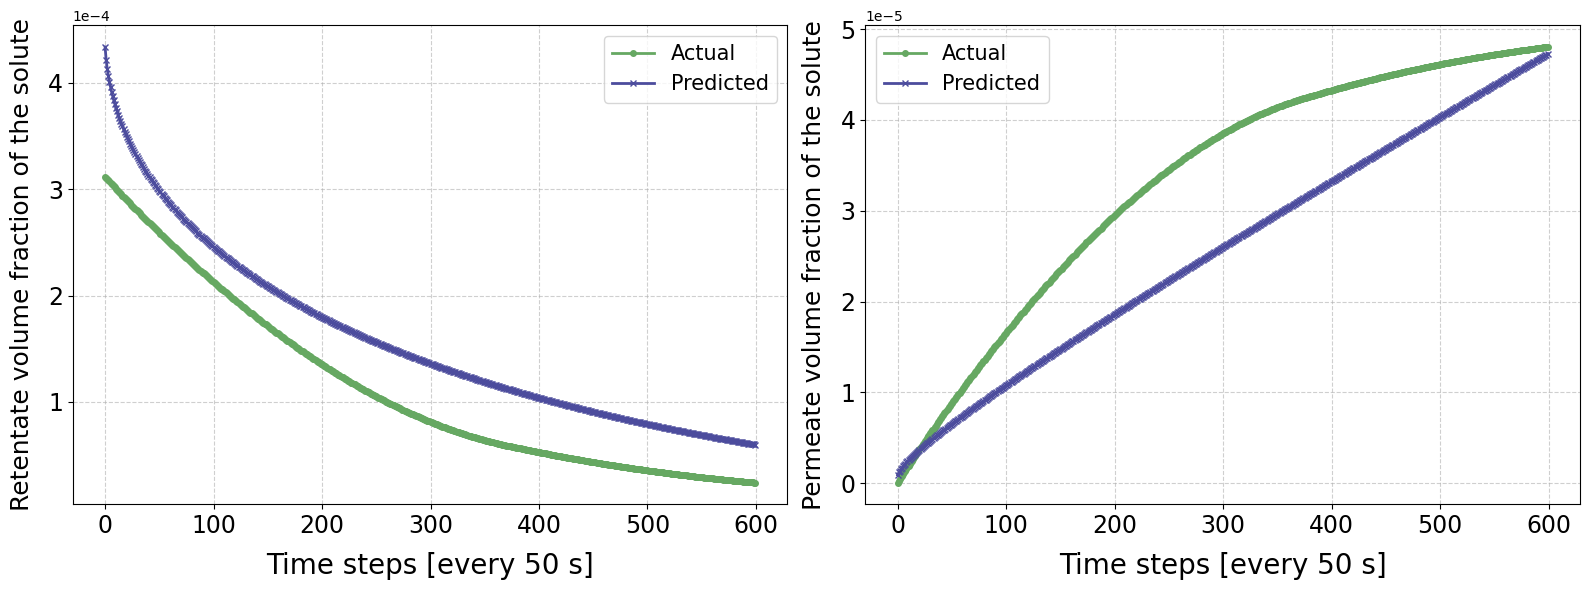

In [13]:
import random
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter
import pandas as pd

# Apply inverse transformation to Y_test before prediction

# Select a random simulation ID from the entire dataset
random_sim_id = 'Sim_6424'

# Filter the data for the selected simulation
X_simulation = X_sqrt[groups == random_sim_id]
Y_simulation = Y_sqrt[groups == random_sim_id]

# Scale the inputs for prediction
X_simulation_scaled = feature_scaler.transform(X_simulation)

# Predict for the chosen simulation
Y_simulation_pred = pls_model_sqrt_2_add.predict(X_simulation_scaled)
Y_simulation_pred = target_scaler.inverse_transform(Y_simulation_pred)
Y_simulation_pred = np.square(Y_simulation_pred)  # Apply inverse transformation

# Convert to DataFrame for easier handling
Y_simulation = np.square(Y_simulation)
Y_simulation_actual_df = pd.DataFrame(Y_simulation, columns=Y.columns)
Y_simulation_pred_df = pd.DataFrame(Y_simulation_pred, columns=Y.columns)

# Choose targets for plotting
target_name_permeate = '5nm_permeate'  # Replace with your desired target
target_name_retentate = '5nm_retentate'  # Replace with your desired target

Y_actual_permeate = Y_simulation_actual_df[target_name_permeate]
Y_pred_permeate = Y_simulation_pred_df[target_name_permeate]

Y_actual_retentate = Y_simulation_actual_df[target_name_retentate]
Y_pred_retentate = Y_simulation_pred_df[target_name_retentate]

# Create a figure with one row and two columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for retentate (first column)
axes[0].plot(Y_actual_retentate.values, label='Actual', marker='o', color='#66a862', linewidth=2, markersize=4)
axes[0].plot(Y_pred_retentate.values, label='Predicted', marker='x', color='#4C4C9D', linewidth=2, markersize=4)
axes[0].set_xlabel('Time steps [every 50 s]', fontsize=20, labelpad=10)
axes[0].set_ylabel('Retentate volume fraction of the solute', fontsize=18, labelpad=10)
axes[0].legend(fontsize=15, loc='best')
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].tick_params(axis='both', which='major', labelsize=17)
axes[0].ticklabel_format(axis='y', style='sci', scilimits=(-3, 3))  # Force scientific notation

# Plot for permeate (second column)
axes[1].plot(Y_actual_permeate.values, label='Actual', marker='o', color='#66a862', linewidth=2, markersize=4)
axes[1].plot(Y_pred_permeate.values, label='Predicted', marker='x', color='#4C4C9D', linewidth=2, markersize=4)
axes[1].set_xlabel('Time steps [every 50 s]', fontsize=20, labelpad=10)
axes[1].set_ylabel('Permeate volume fraction of the solute', fontsize=18, labelpad=10)
axes[1].legend(fontsize=15, loc='best')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].tick_params(axis='both', which='major', labelsize=17)
axes[1].ticklabel_format(axis='y', style='sci', scilimits=(-3, 3))  # Force scientific notation

# Tight layout for better spacing
plt.tight_layout()

# Save the figure as a high-resolution image
plt.savefig('retentate_permeate_comparison_transformed.png', dpi=300)

# Show the plot
plt.show()



Evaluation of PLS models with varying number of components:
Components: 1, R²: 0.4883, MAE: 0.0317, MSE: 0.0301, RMSE: 0.0422
Components: 2, R²: 0.5745, MAE: 0.0311, MSE: 0.0287, RMSE: 0.0412
Components: 3, R²: 0.7262, MAE: 0.0179, MSE: 0.0121, RMSE: 0.0267
Components: 4, R²: 0.7494, MAE: 0.0177, MSE: 0.0117, RMSE: 0.0264
Components: 5, R²: 0.7678, MAE: 0.0166, MSE: 0.0094, RMSE: 0.0236
Components: 6, R²: 0.7715, MAE: 0.0166, MSE: 0.0094, RMSE: 0.0236
Components: 7, R²: 0.7749, MAE: 0.0165, MSE: 0.0094, RMSE: 0.0235
Components: 8, R²: 0.7768, MAE: 0.0165, MSE: 0.0094, RMSE: 0.0235
Components: 9, R²: 0.7791, MAE: 0.0165, MSE: 0.0093, RMSE: 0.0235
Components: 10, R²: 0.7800, MAE: 0.0165, MSE: 0.0093, RMSE: 0.0235


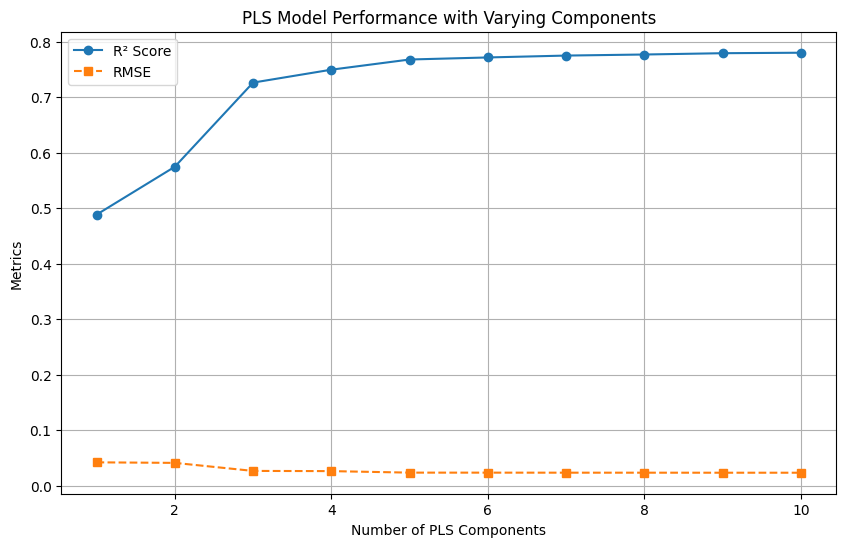

In [35]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# # Add normalized time to the features
# def normalize_time_per_simulation(df, simulation_column, time_column):
# #     df['Normalized_Time'] = df.groupby(simulation_column)[time_column].transform(lambda x: x / x.max())
# #     return df

# # Apply the function to normalize time
sampled_data = normalize_time_per_simulation(sampled_data, simulation_column='Simulation_ID', time_column='Time (s)')

# Define features and targets
features = sampled_data.drop(columns=['Simulation_ID', 'Time (s)', 
                               '5nm_retentate', '5nm_permeate', '5nm_cumulative_yield', '5nm_size_solute',
                               '40nm_retentate', '40nm_permeate', '40nm_cumulative_yield', '40nm_size_solute',
                               '70nm_retentate', '70nm_permeate', '70nm_cumulative_yield', '70nm_size_solute',
                               '120nm_retentate', '120nm_permeate', '120nm_cumulative_yield', '120nm_size_solute',
                               '190nm_retentate', '190nm_permeate', '190nm_cumulative_yield', '190nm_size_solute',
                               '300nm_retentate', '300nm_permeate', '300nm_cumulative_yield', '300nm_size_solute',
                               '700nm_retentate', '700nm_permeate', '700nm_cumulative_yield', '700nm_size_solute',
                               '2500nm_retentate', '2500nm_permeate', '2500nm_cumulative_yield', '2500nm_size_solute',
                               'Diavolumes', '2500nm_sieving_coefficient', '120nm_sieving_coefficient'])

# Apply log transformation to all features
features_transformed = np.sqrt(features)
targets_transformed = np.sqrt(np.where(Y < 0, 0, Y))

# Split data into train-validation and test sets
group_split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_val_idx, test_idx = next(group_split.split(features_transformed, targets_transformed, groups))

features_train_val, features_test = features_transformed.iloc[train_val_idx], features_transformed.iloc[test_idx]
targets_train_val, targets_test = targets_transformed[train_val_idx], targets_transformed[test_idx]
groups_train_val = groups.iloc[train_val_idx]

# Initialize scalers
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# Set up 5-fold cross-validation
n_folds = 5
group_kfold = GroupKFold(n_splits=n_folds)

# Function to evaluate models with different components
def evaluate_pls_model(n_components_list):
    results = []

    for n_components in n_components_list:
        # Initialize placeholders for aggregate metrics
        validation_r2_list, validation_mae_list, validation_mse_list, validation_rmse_list = [], [], [], []

        # Cross-validation loop
        for fold, (train_idx, val_idx) in enumerate(group_kfold.split(features_train_val, targets_train_val, groups_train_val), start=1):
            # Split data
            features_train_fold, features_val_fold = features_train_val.iloc[train_idx], features_train_val.iloc[val_idx]
            targets_train_fold, targets_val_fold = targets_train_val[train_idx], targets_train_val[val_idx]

            # Scale data
            features_train_fold_scaled = feature_scaler.fit_transform(features_train_fold)
            targets_train_fold_scaled = target_scaler.fit_transform(targets_train_fold)
            features_val_fold_scaled = feature_scaler.transform(features_val_fold)
            targets_val_fold_scaled = target_scaler.transform(targets_val_fold)

            # Train the model
            pls_model = PLSRegression(n_components=n_components)
            pls_model.fit(features_train_fold_scaled, targets_train_fold_scaled)

            # Predict on validation set
            targets_val_pred = pls_model.predict(features_val_fold_scaled)
            targets_val_pred = target_scaler.inverse_transform(targets_val_pred)
            targets_val_pred = np.square(targets_val_pred)
            targets_val_fold = np.square(targets_val_fold)

            # Compute metrics
            val_mse = mean_squared_error(targets_val_fold, targets_val_pred, multioutput='raw_values')
            val_rmse = np.sqrt(val_mse)
            val_r2 = r2_score(targets_val_fold, targets_val_pred, multioutput='uniform_average')
            val_mae = mean_absolute_error(targets_val_fold, targets_val_pred, multioutput='raw_values')

            # Aggregate metrics across folds
            validation_r2_list.append(val_r2)
            validation_mae_list.append(np.mean(val_mae))
            validation_mse_list.append(np.mean(val_mse))
            validation_rmse_list.append(np.mean(val_rmse))

        # Compute averages across all folds
        avg_val_r2 = np.mean(validation_r2_list)
        avg_val_mae = np.mean(validation_mae_list)
        avg_val_mse = np.mean(validation_mse_list)
        avg_val_rmse = np.mean(validation_rmse_list)

        results.append((n_components, avg_val_r2, avg_val_mae, avg_val_mse, avg_val_rmse))

    return results

# Test different numbers of components
n_components_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
results = evaluate_pls_model(n_components_list)

# Display results
print("\nEvaluation of PLS models with varying number of components:")
for n_components, avg_val_r2, avg_val_mae, avg_val_mse, avg_val_rmse in results:
    print(f"Components: {n_components}, R²: {avg_val_r2:.4f}, MAE: {avg_val_mae:.4f}, MSE: {avg_val_mse:.4f}, RMSE: {avg_val_rmse:.4f}")

# Plot the results
components, r2_scores, maes, mses, rmses = zip(*results)
plt.figure(figsize=(10, 6))
plt.plot(components, r2_scores, marker='o', linestyle='-', label='R² Score')
plt.plot(components, rmses, marker='s', linestyle='--', label='RMSE')
plt.xlabel('Number of PLS Components')
plt.ylabel('Metrics')
plt.title('PLS Model Performance with Varying Components')
plt.legend()
plt.grid(True)
plt.show()
